<a href="https://colab.research.google.com/github/roguxivlo/machine-learning-24L/blob/main/hw9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [89]:
import torch
import torchvision
from matplotlib import pyplot as plt

torch.manual_seed(42)
torch.cuda.manual_seed(42)

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

In [90]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

In [91]:

# First copy the mnist classifier from classes:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

In [92]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()
# For development speed up, only train for 1 epoch:
for epoch in range(8):

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)

        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()



Working on cuda
epoch: 0 batch: 0 current batch loss: 2.310203790664673
epoch: 0 batch: 1 current batch loss: 2.0768327713012695
epoch: 0 batch: 2 current batch loss: 1.624901294708252
epoch: 0 batch: 3 current batch loss: 1.1932710409164429
epoch: 0 batch: 4 current batch loss: 1.1437439918518066
epoch: 0 batch: 5 current batch loss: 0.9622821807861328
epoch: 0 batch: 6 current batch loss: 0.9507745504379272
epoch: 0 batch: 7 current batch loss: 0.8162147998809814
epoch: 0 batch: 8 current batch loss: 0.7120282053947449
epoch: 0 batch: 9 current batch loss: 0.6511026620864868
epoch: 0 batch: 10 current batch loss: 0.6360457539558411
epoch: 0 batch: 11 current batch loss: 0.6028648018836975
epoch: 0 batch: 12 current batch loss: 0.5230752825737
epoch: 0 batch: 13 current batch loss: 0.5151314735412598
epoch: 0 batch: 14 current batch loss: 0.4442121982574463
epoch: 0 batch: 15 current batch loss: 0.4606562554836273
epoch: 0 batch: 16 current batch loss: 0.46927446126937866
epoch: 0 bat

In [93]:
# Now we create another model, whose job will be to
# generate an image that MNIST classifier thinks
# to be a given digit


class Anti_MNIST(torch.nn.Module):
    def __init__ (self, trained_classifier):
        super().__init__()
        self.imgs = torch.nn.Parameter(torch.randn((10, 1, 28, 28)))
        self.classifier = trained_classifier # Ensure this is trained!

    def forward(self, _): # ignore x, we don't care
        output = self.classifier(self.imgs)
        return output




In [94]:
# Let's now train our anti_mnist classifier:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net.eval()
for param in net.parameters():
    param.requires_grad = False


anti_model = Anti_MNIST(net).to(device)
optimizer = torch.optim.Adam(anti_model.parameters(), 0.001)

anti_model.train()

goal_vector = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)

for epoch in range(5000):
    optimizer.zero_grad()
    output = anti_model(0) # x doesn't matter

    loss = torch.nn.functional.cross_entropy(output, goal_vector, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch+1}, Current Loss: {loss.item():.4f}")

    loss.backward()       #this computes gradients as we have seen in previous workshops
    optimizer.step()


Working on cuda
Epoch: 100, Current Loss: 1.8324
Epoch: 200, Current Loss: 0.4122
Epoch: 300, Current Loss: 0.0835
Epoch: 400, Current Loss: 0.0586
Epoch: 500, Current Loss: 0.0372
Epoch: 600, Current Loss: 0.0438
Epoch: 700, Current Loss: 0.0931
Epoch: 800, Current Loss: 0.0134
Epoch: 900, Current Loss: 0.0076
Epoch: 1000, Current Loss: 0.0070
Epoch: 1100, Current Loss: 0.0820
Epoch: 1200, Current Loss: 0.0152
Epoch: 1300, Current Loss: 0.0223
Epoch: 1400, Current Loss: 0.0177
Epoch: 1500, Current Loss: 0.0212
Epoch: 1600, Current Loss: 0.0068
Epoch: 1700, Current Loss: 0.0026
Epoch: 1800, Current Loss: 0.0022
Epoch: 1900, Current Loss: 0.0140
Epoch: 2000, Current Loss: 0.0028
Epoch: 2100, Current Loss: 0.0014
Epoch: 2200, Current Loss: 0.0037
Epoch: 2300, Current Loss: 0.0023
Epoch: 2400, Current Loss: 0.0046
Epoch: 2500, Current Loss: 0.0023
Epoch: 2600, Current Loss: 0.0017
Epoch: 2700, Current Loss: 0.0014
Epoch: 2800, Current Loss: 0.0724
Epoch: 2900, Current Loss: 0.0008
Epoch: 


Predicted labels for generated images: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


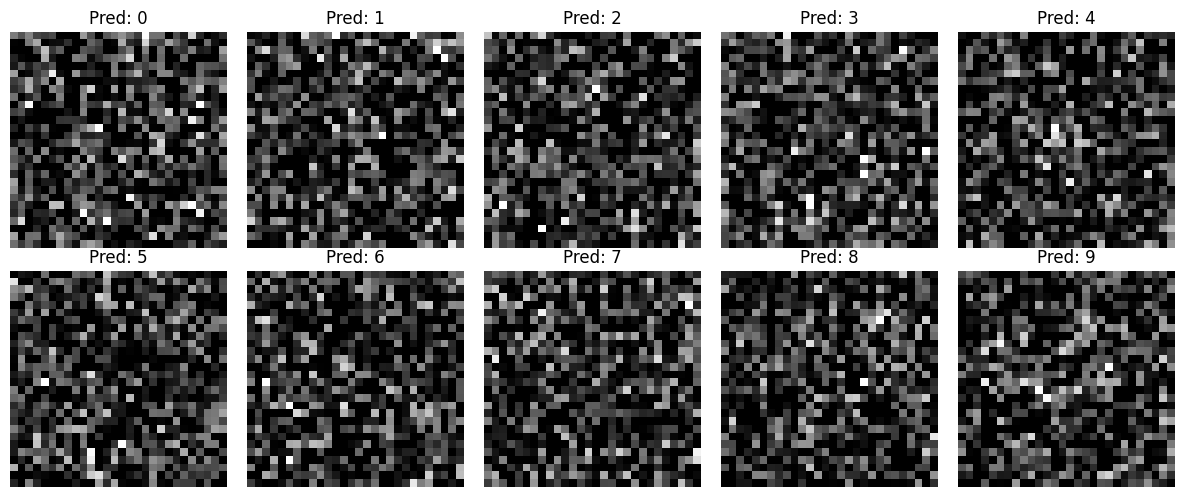

In [95]:
# Get the images from the anti_model:

anti_model.eval()
with torch.no_grad():
    final_output = anti_model(0)
    predicted_labels = torch.argmax(final_output, dim=1)
    print(f"\nPredicted labels for generated images: {predicted_labels.tolist()}")


generated_images = anti_model.imgs.detach().cpu().squeeze(1).numpy()
# Define the mean and standard deviation used for original normalization
mean = 0.1307
std = 0.3081


denormalized_images = generated_images * std + mean
denormalized_images = denormalized_images.clip(0, 1) # Clamp values to be between 0 and 1


# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 5)) # 2 rows, 5 columns for 10 images
axes = axes.flatten() # Flatten the 2x5 array of axes for easy iteration

for i in range(10):
    # Display each image
    axes[i].imshow(denormalized_images[i], cmap='gray')
    # Set title with the predicted label
    axes[i].set_title(f"Pred: {predicted_labels[i].item()}")
    axes[i].axis('off') # Hide axes ticks

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot

# Task 1 Discussion:
The images we obtained don't resemble real digits at all. This can be explained by several arguments:

- The gradient descent algorithm just looks for the quickest path to the local minimum of loss function, it isn't guaranteed that all minima lie near "real digits"

- The model might have learned some obscure features that differentiate digits well, but are unnoticeable for human eye

It seems that there's no good reason to expect the generated images to look like digits with this training procedure

In [96]:
# Let's work on task 2:
# The solution will be nearly the same, main changes in the loss function
# will be described below.


class Anti_MNIST_task_2(torch.nn.Module):
    def __init__ (self, trained_classifier):
        super().__init__()
        self.imgs = torch.nn.Parameter(torch.randn((1, 1, 28, 28))) # now only one image!
        self.classifier = trained_classifier # Ensure this is trained!

    def forward(self, _): # ignore x, we don't care
        output = self.classifier(self.imgs)
        return output

In [97]:
# Let's now train our anti_mnist classifier for task 2:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net.eval()
for param in net.parameters():
    param.requires_grad = False


anti_model = Anti_MNIST_task_2(net).to(device)
optimizer = torch.optim.Adam(anti_model.parameters(), 0.001)

anti_model.train()

# Assume that we want the model to confuse 1 and 7:

goal_vector = torch.tensor([0,.5, 0, 0, 0, 0, 0, .5, 0, 0]).to(device)

for epoch in range(5000):
    optimizer.zero_grad()
    output = anti_model(0) # x doesn't matter

    # Convert logits to log-probabilities (required by KLDivLoss)
    log_probs = torch.nn.functional.log_softmax(output, dim=1)

    # loss = torch.nn.functional.cross_entropy(output, goal_vector, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
    loss = torch.nn.functional.kl_div(log_probs, goal_vector.unsqueeze(0), reduction="batchmean")
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch+1}, Current Loss: {loss.item():.4f}")

    loss.backward()       #this computes gradients as we have seen in previous workshops
    optimizer.step()


Working on cuda
Epoch: 100, Current Loss: 1.4873
Epoch: 200, Current Loss: 0.4544
Epoch: 300, Current Loss: 0.1261
Epoch: 400, Current Loss: 0.0214
Epoch: 500, Current Loss: 0.0127
Epoch: 600, Current Loss: 0.1105
Epoch: 700, Current Loss: 0.1896
Epoch: 800, Current Loss: 0.0059
Epoch: 900, Current Loss: 0.0748
Epoch: 1000, Current Loss: 0.0049
Epoch: 1100, Current Loss: 0.0053
Epoch: 1200, Current Loss: 0.0046
Epoch: 1300, Current Loss: 0.0063
Epoch: 1400, Current Loss: 0.0065
Epoch: 1500, Current Loss: 0.0048
Epoch: 1600, Current Loss: 0.3720
Epoch: 1700, Current Loss: 0.0056
Epoch: 1800, Current Loss: 0.0034
Epoch: 1900, Current Loss: 0.0044
Epoch: 2000, Current Loss: 0.0748
Epoch: 2100, Current Loss: 0.0699
Epoch: 2200, Current Loss: 0.0029
Epoch: 2300, Current Loss: 0.0025
Epoch: 2400, Current Loss: 0.0040
Epoch: 2500, Current Loss: 0.0063
Epoch: 2600, Current Loss: 0.0674
Epoch: 2700, Current Loss: 0.0022
Epoch: 2800, Current Loss: 0.0070
Epoch: 2900, Current Loss: 0.0037
Epoch: 


Predicted labels for generated images: [1]


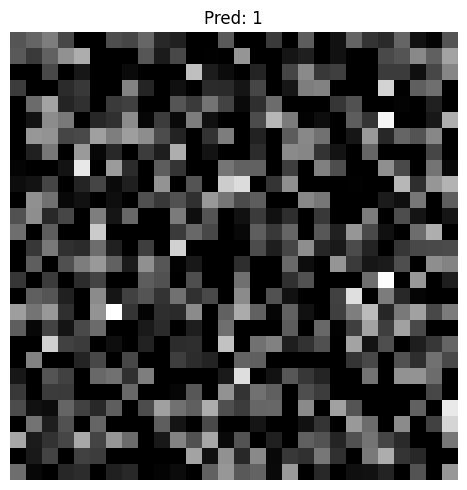

In [98]:
# Get the images from the anti_model:

anti_model.eval()
with torch.no_grad():
    final_output = anti_model(0)
    predicted_labels = torch.argmax(final_output, dim=1)
    print(f"\nPredicted labels for generated images: {predicted_labels.tolist()}")


generated_images = anti_model.imgs.detach().cpu().squeeze(1).numpy()
# Define the mean and standard deviation used for original normalization
mean = 0.1307
std = 0.3081


denormalized_images = generated_images * std + mean
denormalized_images = denormalized_images.clip(0, 1) # Clamp values to be between 0 and 1


# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 1, figsize=(12, 5)) # 2 rows, 5 columns for 10 images

for i in range(1):
    # Display each image
    axes.imshow(denormalized_images[i], cmap='gray')
    # Set title with the predicted label
    axes.set_title(f"Pred: {predicted_labels[i].item()}")
    axes.axis('off') # Hide axes ticks

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot

# Task 2 Discussion
Why did we use the KL divergence as the loss function?
Because here our goal is not to predict a single label, but rather a probability ditribution. Cross Entropy function works only for label prediction tasks.

# Task 3

In [99]:
# Let's now train our anti_mnist classifier:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net.eval()
for param in net.parameters():
    param.requires_grad = False


anti_model_task_3a = Anti_MNIST(net).to(device)
optimizer = torch.optim.Adam(anti_model_task_3a.parameters(), 0.001)

anti_model_task_3a.train()

goal_vector = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)

start_lambda_l2 = 0.001
end_lambda_l2 = 10.0

total_epochs = 10000

for epoch in range(total_epochs):
    optimizer.zero_grad()
    output = anti_model_task_3a(0) # x doesn't matter

    loss = torch.nn.functional.cross_entropy(output, goal_vector, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function

    exponent = epoch / (total_epochs - 1)
    current_lambda_l2 = start_lambda_l2 * (end_lambda_l2 / start_lambda_l2)**exponent

    l2_penalty = current_lambda_l2 * anti_model_task_3a.imgs.pow(2).mean() # L2 penalty on pixel values

    total_loss = loss + l2_penalty

    if (epoch + 1) % 500 == 0:
        print(f"Epoch: {epoch+1}, Current Loss: {loss.item():.4f}")

    total_loss.backward()       #this computes gradients as we have seen in previous workshops
    optimizer.step()


Working on cuda
Epoch: 500, Current Loss: 0.0262
Epoch: 1000, Current Loss: 0.1188
Epoch: 1500, Current Loss: 0.0107
Epoch: 2000, Current Loss: 0.0037
Epoch: 2500, Current Loss: 0.0023
Epoch: 3000, Current Loss: 0.0725
Epoch: 3500, Current Loss: 0.0006
Epoch: 4000, Current Loss: 0.0005
Epoch: 4500, Current Loss: 0.0006
Epoch: 5000, Current Loss: 0.0006
Epoch: 5500, Current Loss: 0.0791
Epoch: 6000, Current Loss: 0.0012
Epoch: 6500, Current Loss: 0.0081
Epoch: 7000, Current Loss: 0.0012
Epoch: 7500, Current Loss: 0.0006
Epoch: 8000, Current Loss: 0.0306
Epoch: 8500, Current Loss: 0.0292
Epoch: 9000, Current Loss: 0.0059
Epoch: 9500, Current Loss: 0.0468
Epoch: 10000, Current Loss: 0.1486



Predicted labels for generated images: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


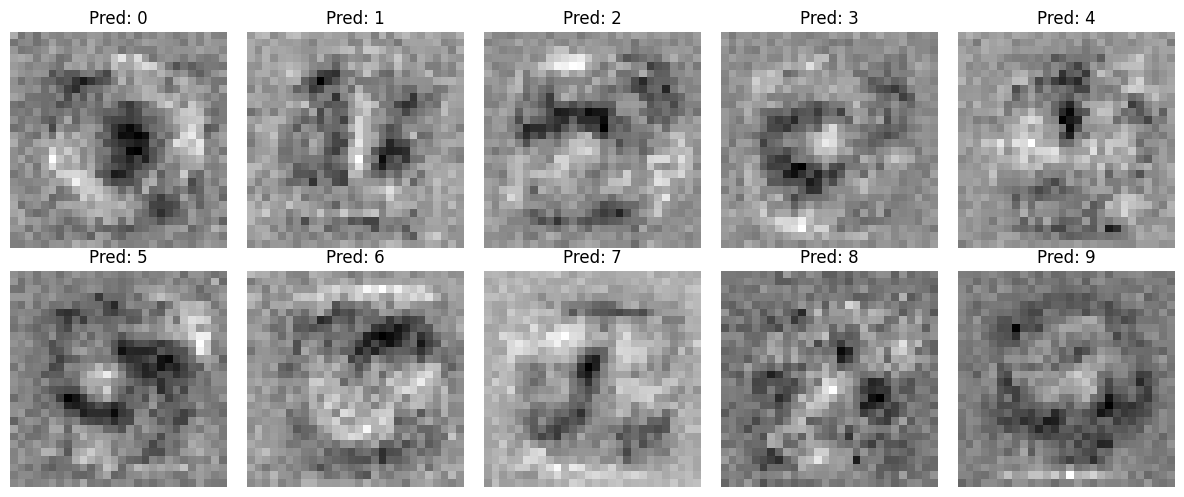

In [100]:
# Get the images from the anti_model_task_3a:

anti_model_task_3a.eval()
with torch.no_grad():
    final_output = anti_model_task_3a(0)
    predicted_labels = torch.argmax(final_output, dim=1)
    print(f"\nPredicted labels for generated images: {predicted_labels.tolist()}")


generated_images = anti_model_task_3a.imgs.detach().cpu().squeeze(1).numpy()
# Define the mean and standard deviation used for original normalization
mean = 0.1307
std = 0.3081


denormalized_images = generated_images * std + mean
denormalized_images = denormalized_images.clip(0, 1) # Clamp values to be between 0 and 1


# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 5)) # 2 rows, 5 columns for 10 images
axes = axes.flatten() # Flatten the 2x5 array of axes for easy iteration

for i in range(10):
    # Display each image
    axes[i].imshow(denormalized_images[i], cmap='gray')
    # Set title with the predicted label
    axes[i].set_title(f"Pred: {predicted_labels[i].item()}")
    axes[i].axis('off') # Hide axes ticks

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot

In [101]:
# Now let's train the model that generates two digits combined in one image:

# Let's now train our anti_mnist classifier for task 2:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net.eval()
for param in net.parameters():
    param.requires_grad = False


anti_model_task_3b = Anti_MNIST_task_2(net).to(device)
optimizer = torch.optim.Adam(anti_model_task_3b.parameters(), 0.001)

anti_model_task_3b.train()

# Assume that we want the model to confuse 1 and 7:

goal_vector = torch.tensor([0,.5, 0, 0, 0, 0, 0, .5, 0, 0]).to(device)

total_epochs = 10000

start_lambda_l2 = 0.001
end_lambda_l2 = 10.0

for epoch in range(total_epochs):
    optimizer.zero_grad()
    output = anti_model_task_3b(0) # x doesn't matter

    # Convert logits to log-probabilities (required by KLDivLoss)
    log_probs = torch.nn.functional.log_softmax(output, dim=1)

    # loss = torch.nn.functional.cross_entropy(output, goal_vector, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
    loss = torch.nn.functional.kl_div(log_probs, goal_vector.unsqueeze(0), reduction="batchmean")

    exponent = epoch / (total_epochs - 1)
    current_lambda_l2 = start_lambda_l2 * (end_lambda_l2 / start_lambda_l2)**exponent

    l2_penalty = current_lambda_l2 * anti_model_task_3b.imgs.pow(2).mean() # L2 penalty on pixel values

    total_loss = loss + l2_penalty

    if (epoch + 1) % 500 == 0:
        print(f"Epoch: {epoch+1}, Current Loss: {loss.item():.4f}")

    total_loss.backward()       #this computes gradients as we have seen in previous workshops
    optimizer.step()


Working on cuda
Epoch: 500, Current Loss: 0.0157
Epoch: 1000, Current Loss: 0.0047
Epoch: 1500, Current Loss: 0.0046
Epoch: 2000, Current Loss: 0.0086
Epoch: 2500, Current Loss: 0.0905
Epoch: 3000, Current Loss: 0.0023
Epoch: 3500, Current Loss: 0.0029
Epoch: 4000, Current Loss: 0.0035
Epoch: 4500, Current Loss: 0.0038
Epoch: 5000, Current Loss: 0.0023
Epoch: 5500, Current Loss: 0.0033
Epoch: 6000, Current Loss: 0.0032
Epoch: 6500, Current Loss: 0.0041
Epoch: 7000, Current Loss: 0.0102
Epoch: 7500, Current Loss: 0.0065
Epoch: 8000, Current Loss: 0.0874
Epoch: 8500, Current Loss: 0.0165
Epoch: 9000, Current Loss: 0.0210
Epoch: 9500, Current Loss: 0.1000
Epoch: 10000, Current Loss: 0.1068



Predicted labels for generated images: [7]


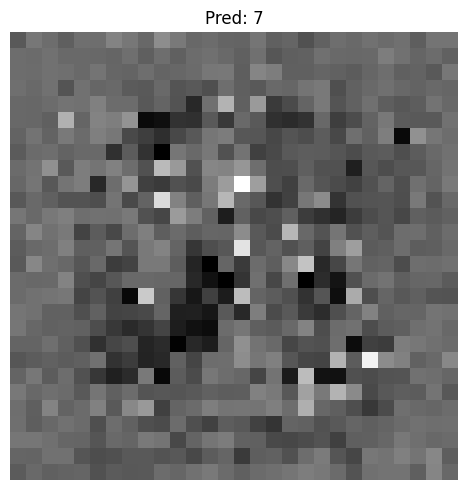

In [102]:
# Get the images from the anti_model:

anti_model_task_3b.eval()
with torch.no_grad():
    final_output = anti_model_task_3b(0)
    predicted_labels = torch.argmax(final_output, dim=1)
    print(f"\nPredicted labels for generated images: {predicted_labels.tolist()}")


generated_images = anti_model_task_3b.imgs.detach().cpu().squeeze(1).numpy()
# Define the mean and standard deviation used for original normalization
mean = 0.1307
std = 0.3081


denormalized_images = generated_images * std + mean
denormalized_images = denormalized_images.clip(0, 1) # Clamp values to be between 0 and 1


# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 1, figsize=(12, 5)) # 2 rows, 5 columns for 10 images

for i in range(1):
    # Display each image
    axes.imshow(denormalized_images[i], cmap='gray')
    # Set title with the predicted label
    axes.set_title(f"Pred: {predicted_labels[i].item()}")
    axes.axis('off') # Hide axes ticks

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot


# Conclusions:

Adding $\ell_2$ penalty significantly improves digit quality. This might be because this penalty forces our models to use less extreme-valued pixels. This introduces the emphasis on image quality instead of only mathematical label.